<a href="https://colab.research.google.com/github/cyber-noob/EDA-on-Ashrae-Energy-Prediction/blob/main/PDP_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 50
sns.set()
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
building = pd.read_csv('/content/drive/MyDrive/Kaggle/building_metadata(m).csv')
weather_train = pd.read_csv('/content/drive/MyDrive/Kaggle/weather_train(m).csv')
weather_test = pd.read_csv('/content/drive/MyDrive/Kaggle/weather_test.csv')
train = pd.read_csv('/content/drive/MyDrive/Kaggle/train(m).csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/test(m).csv')

In [ ]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

In [ ]:
train.head()

building_id  meter  ... wind_direction  wind_speed
0            0      0  ...            0.0         0.0
1            1      0  ...            0.0         0.0
2            2      0  ...            0.0         0.0
3            3      0  ...            0.0         0.0
4            4      0  ...            0.0         0.0

[5 rows x 16 columns]

In [ ]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train = reduce_mem_usage(train, use_float16=True)
test = reduce_mem_usage(test, use_float16=True)

Memory usage of dataframe is 3084.73 MB
Memory usage after optimization is: 983.64 MB
Decreased by 68.1%
Memory usage of dataframe is 6044.42 MB
Memory usage after optimization is: 1869.76 MB
Decreased by 69.1%


In [ ]:
train.drop(['Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0'], axis=1,inplace=True)
test.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis=1,inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int64         
 1   meter               int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int64         
 5   primary_use         object        
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         float64       
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 2.6+ GB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   row_id              int64  
 1   building_id         int64  
 2   meter               int64  
 3   timestamp           object 
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(9), int64(5), object(2)
memory usage: 5.3+ GB


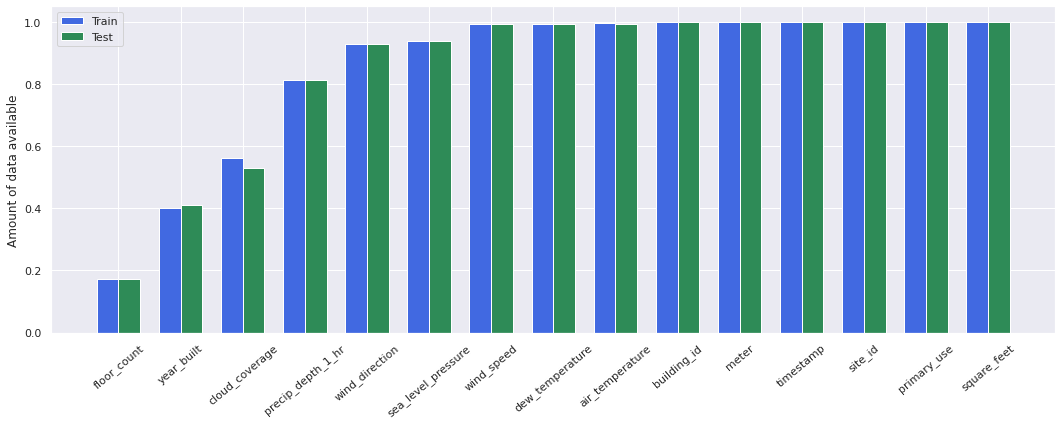

In [ ]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(18, 6))
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);
plt.show()

In [ ]:
train['timestamp'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
test['timestamp'] = pd.to_datetime(test['timestamp'], format='%Y-%m-%d %H:%M:%S')

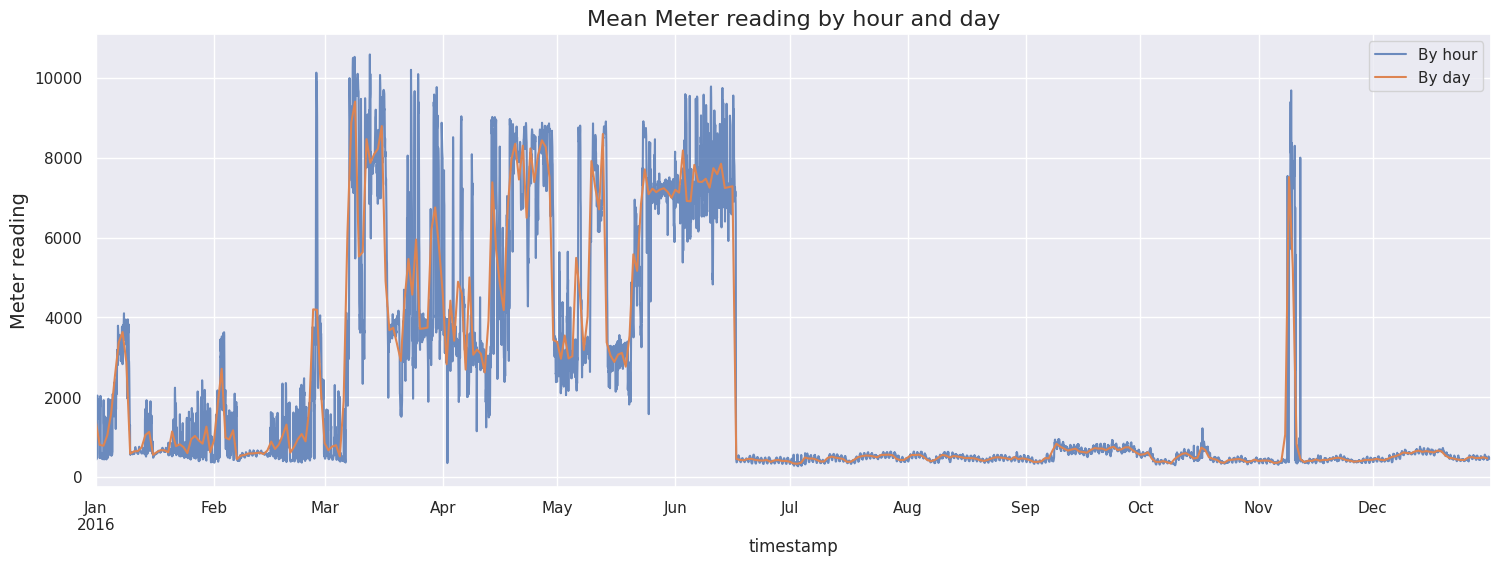

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

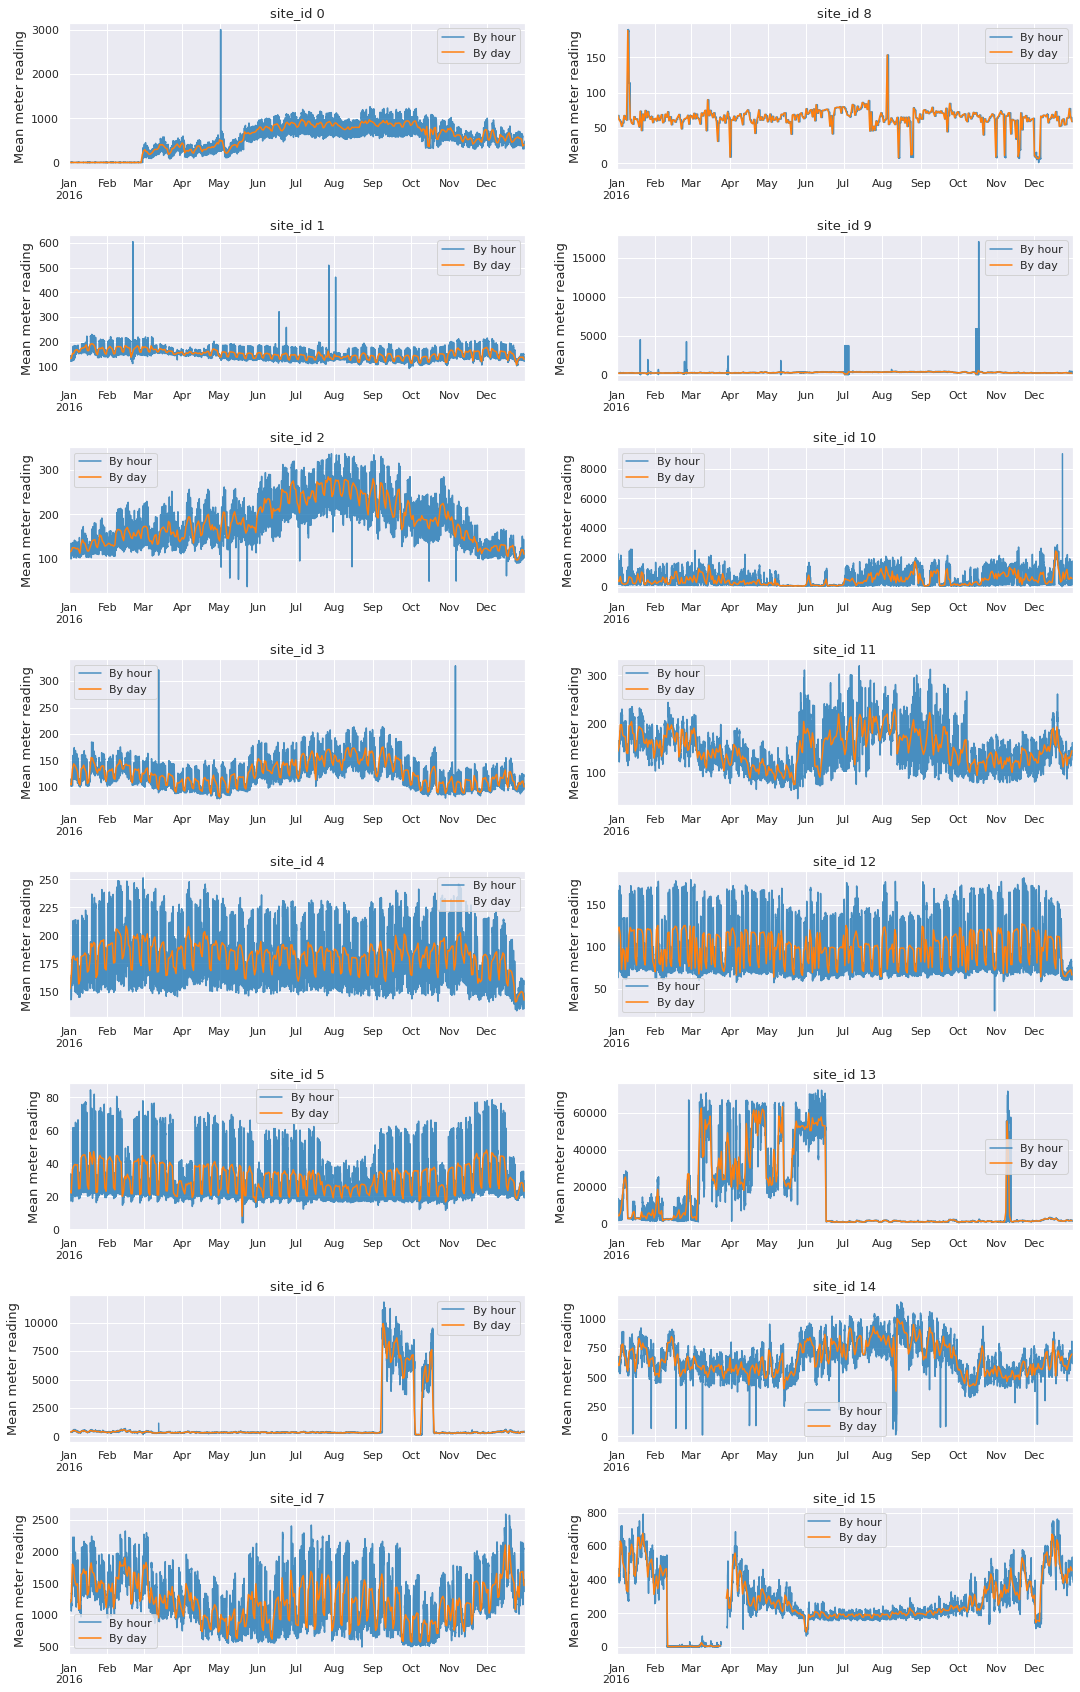

In [ ]:
fig, axes = plt.subplots(8,2,figsize=(18, 30))
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

IndexError: ignored

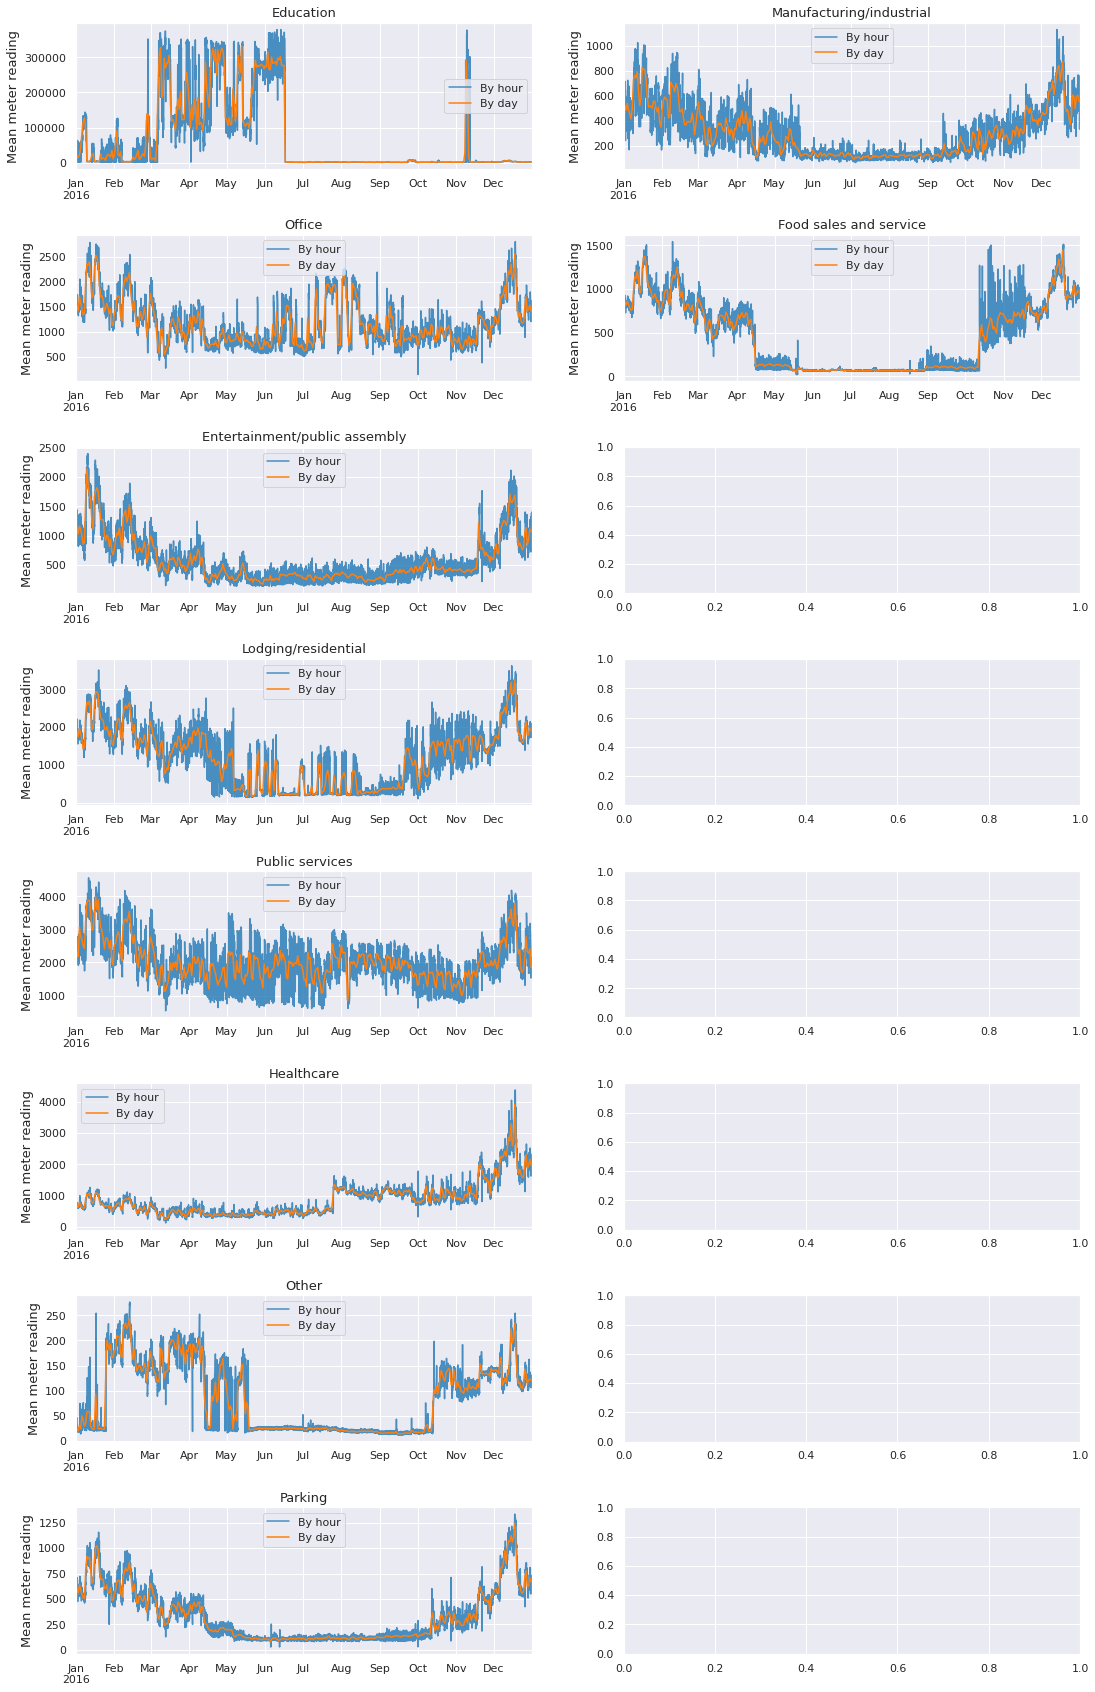

In [ ]:
fig, axes = plt.subplots(8,2,figsize=(18, 30))
for i, use in enumerate(train['primary_use'].value_counts().index.to_list()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
        axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

# ***Mean meter reading by meter type for primary_use==Education and site_id==13***

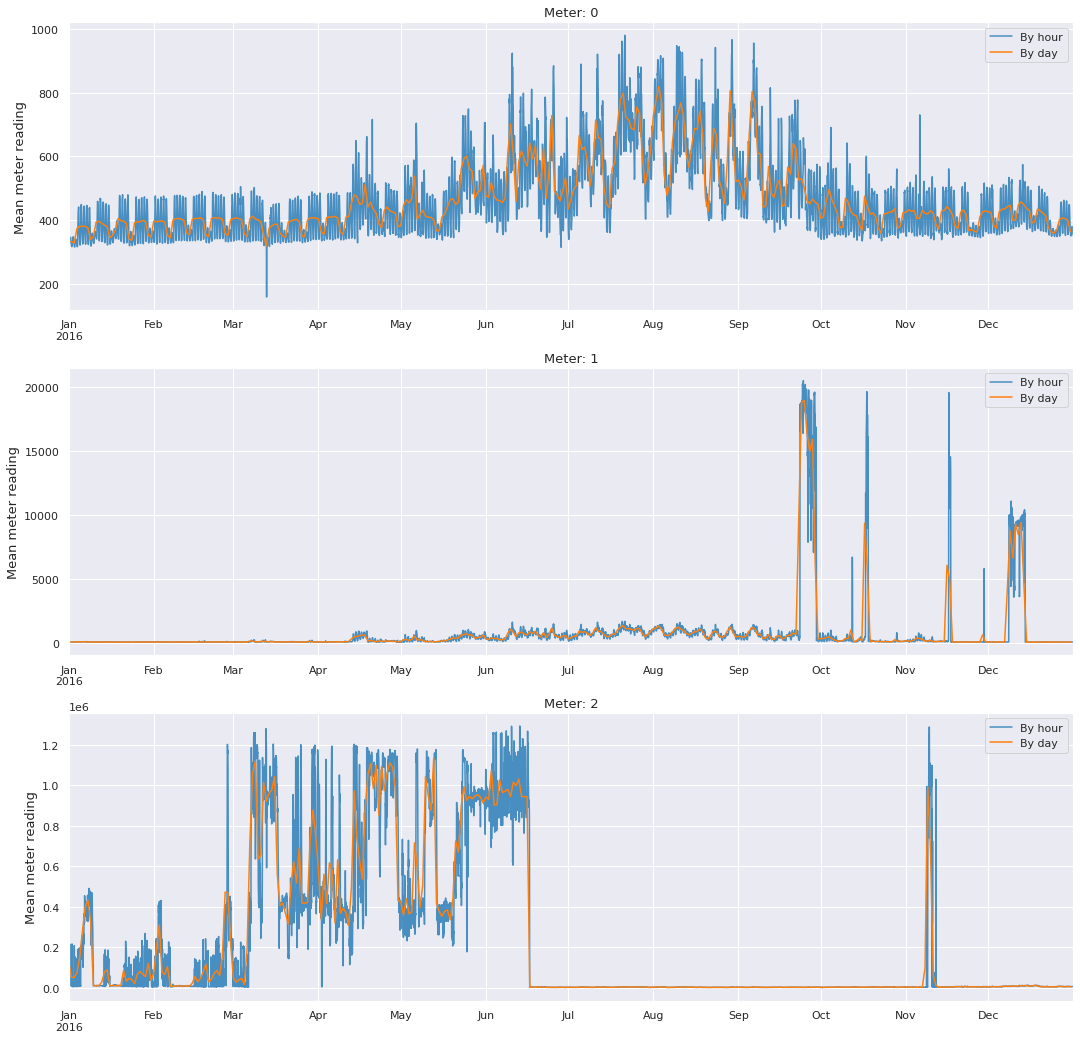

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(18, 18))
for i in train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

**Diving deep into site_id 13 with primary_use Education and meter type 2 for more clarity**

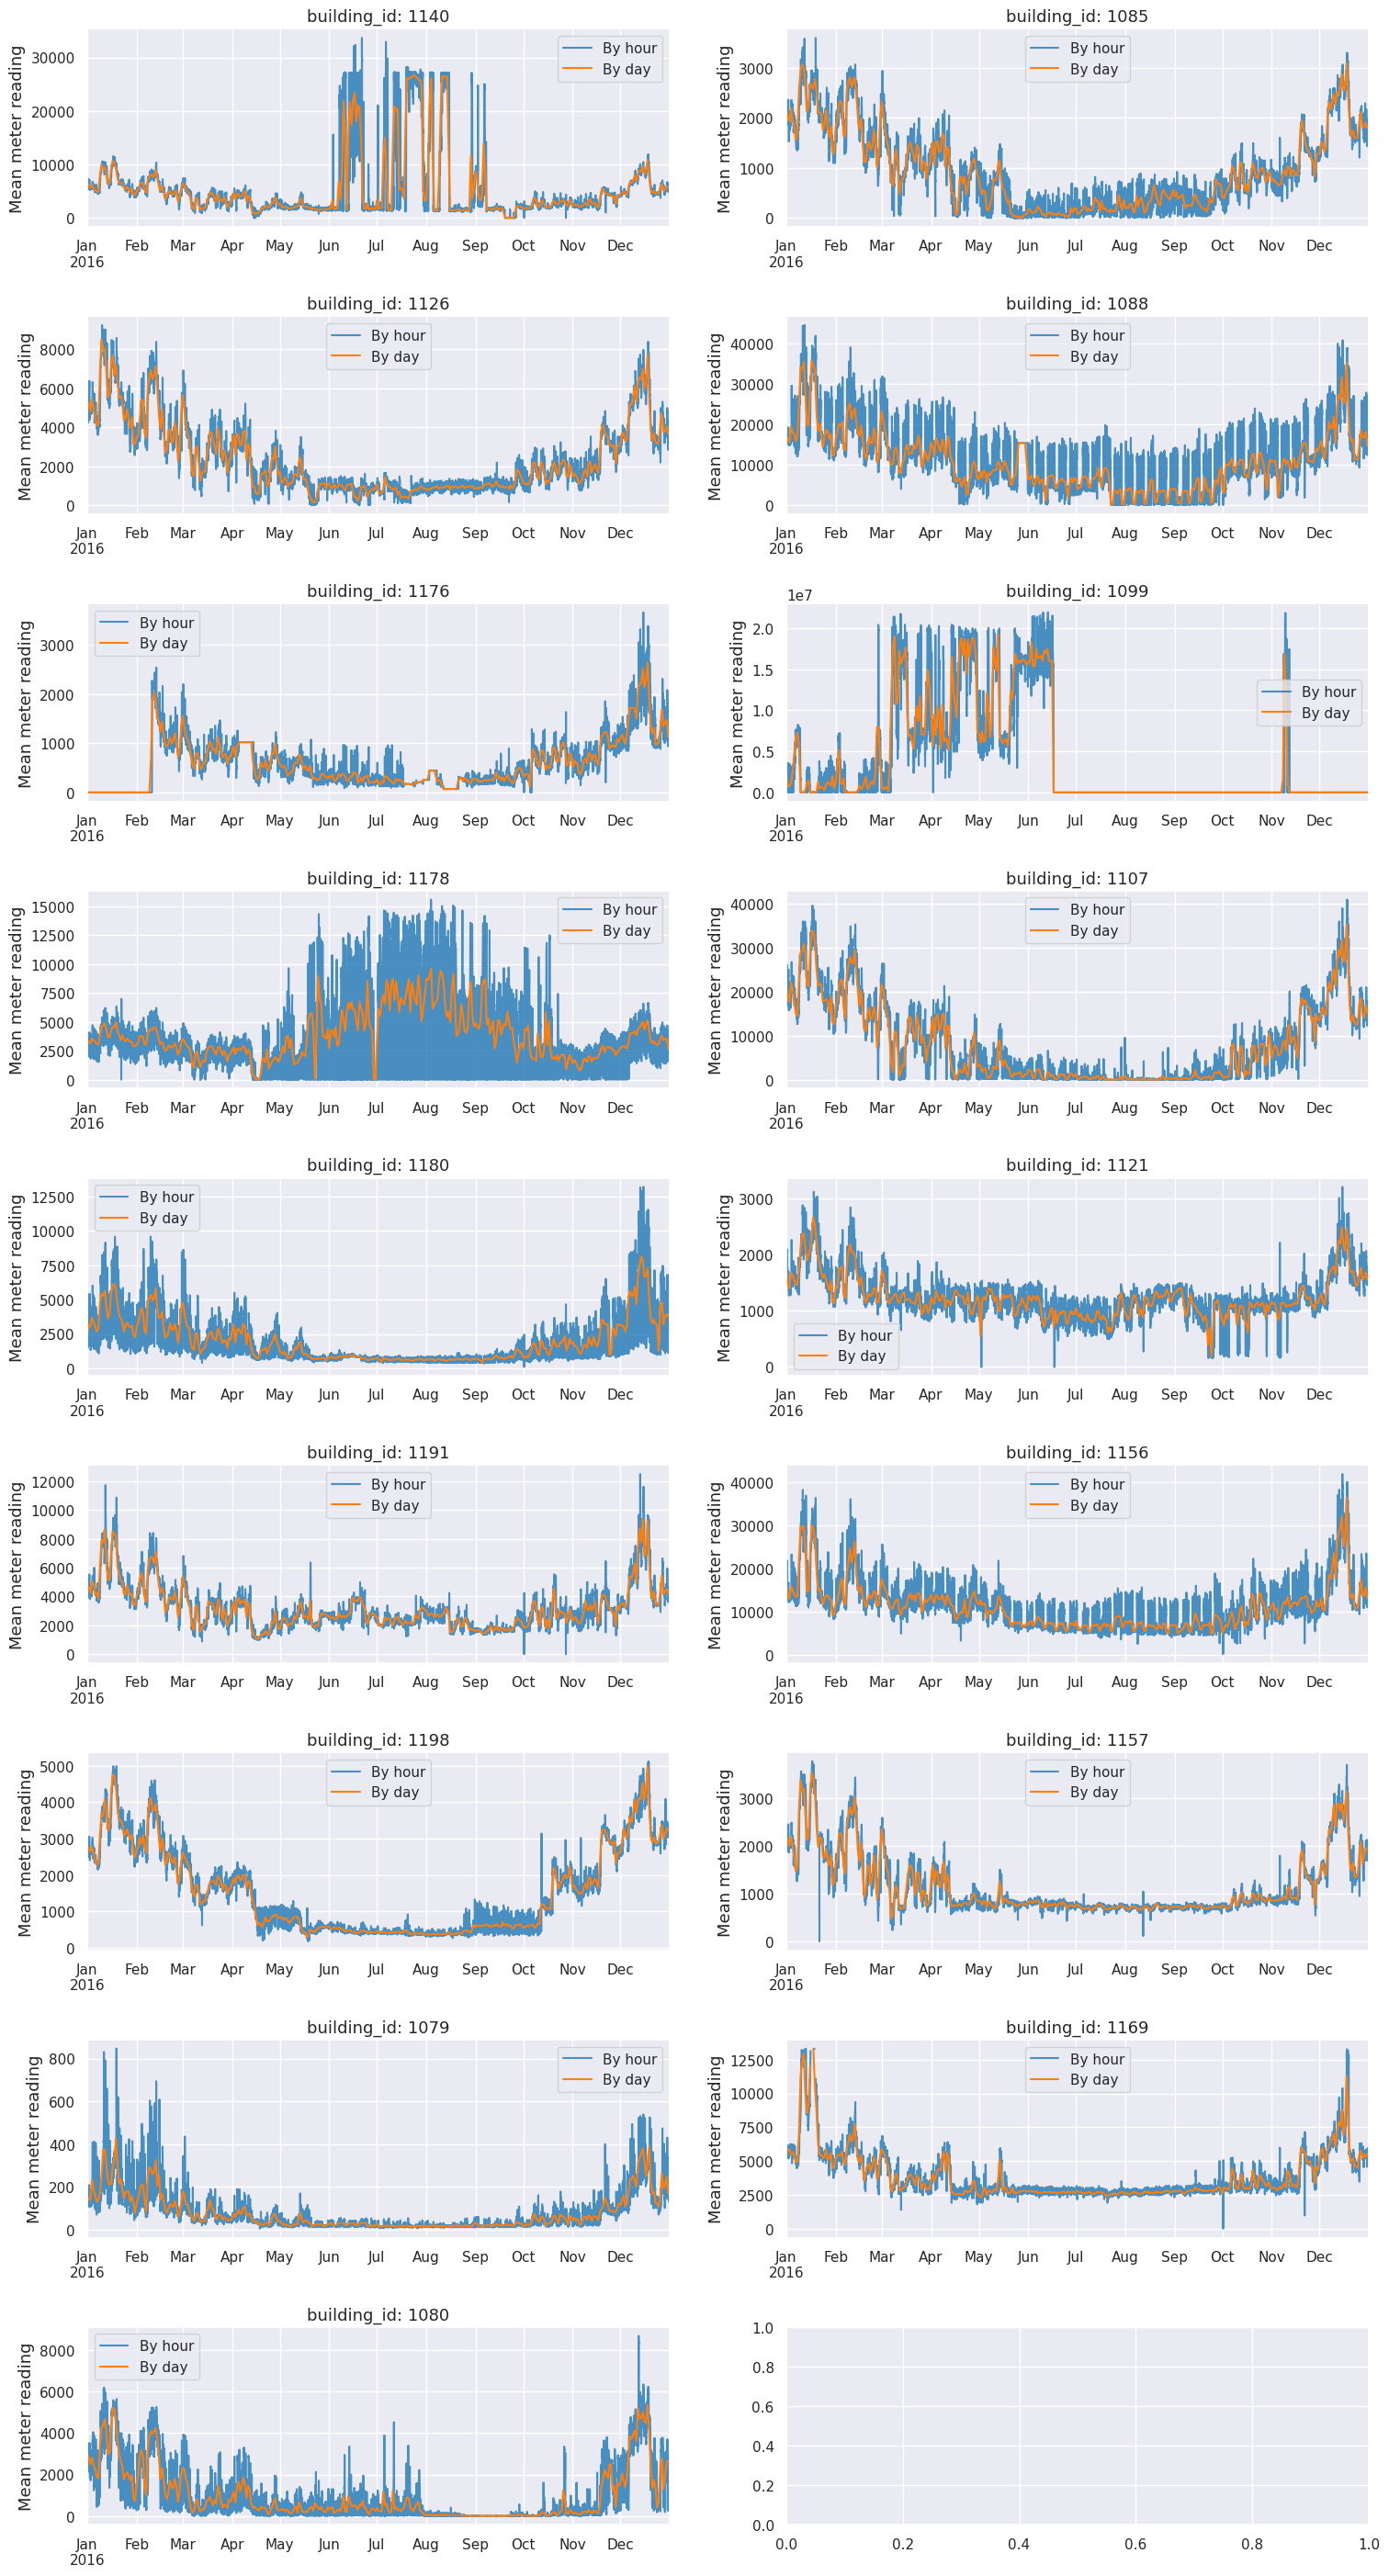

In [ ]:
fig, axes = plt.subplots(9,2,figsize=(18, 36), dpi=100)
for i, building in enumerate(train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2)]['building_id'].value_counts(dropna=False).index.to_list()):
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

**Insights: It was building 1099 which was responsible for such a skewed response. 
Now let's drop building 1099 and check if our meter type 2 is rectified**

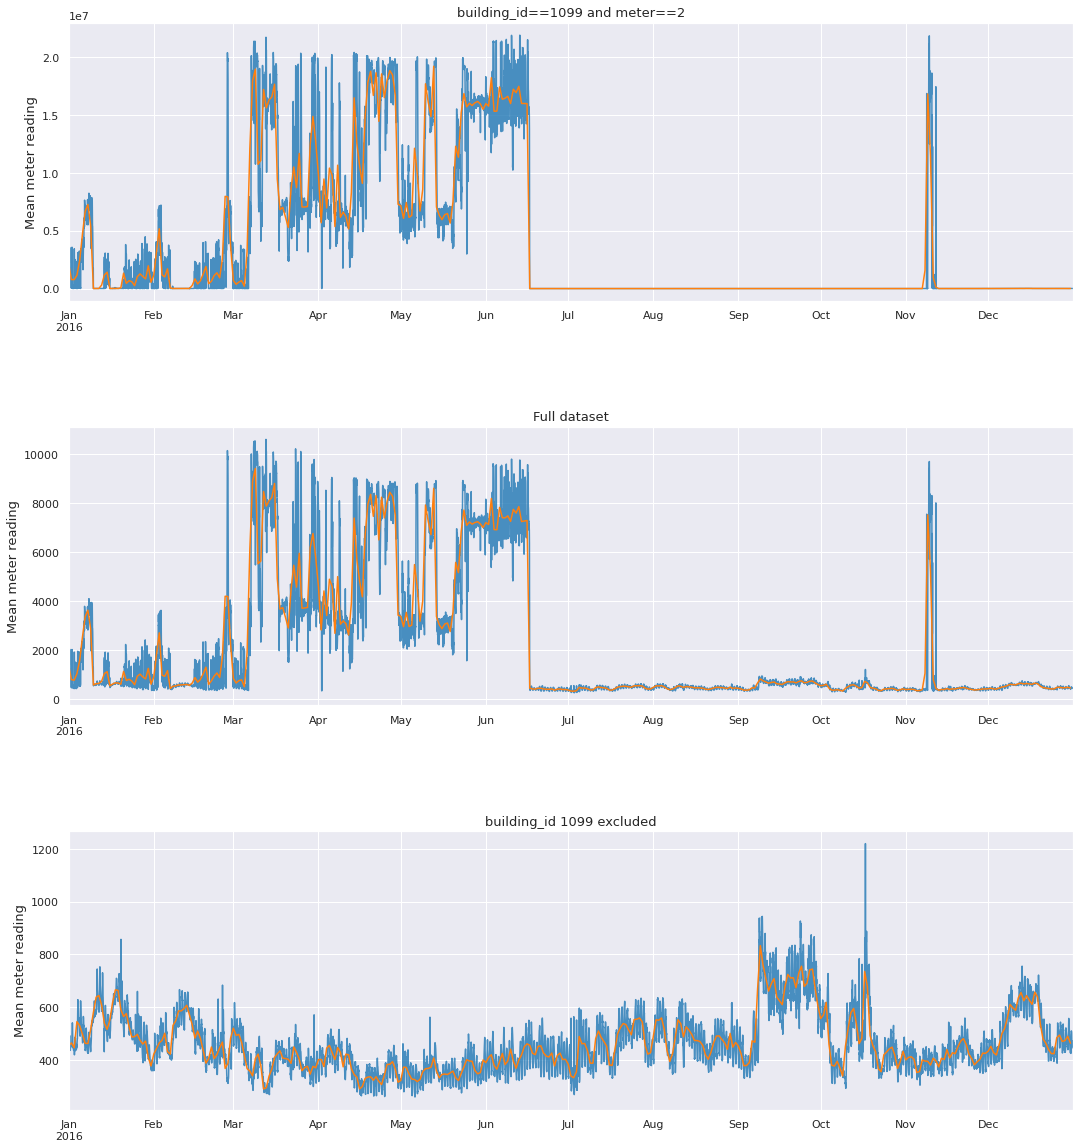

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(18, 20))
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[0], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[2], alpha=1, label='By day', color='tab:orange').set_xlabel('');

axes[0].set_title('building_id==1099 and meter==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('building_id 1099 excluded', fontsize=13);
plt.subplots_adjust(hspace=0.45)

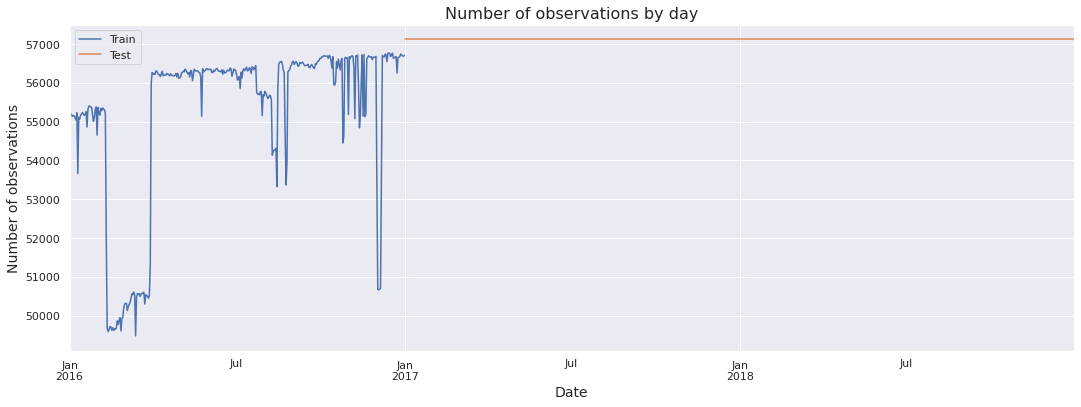

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

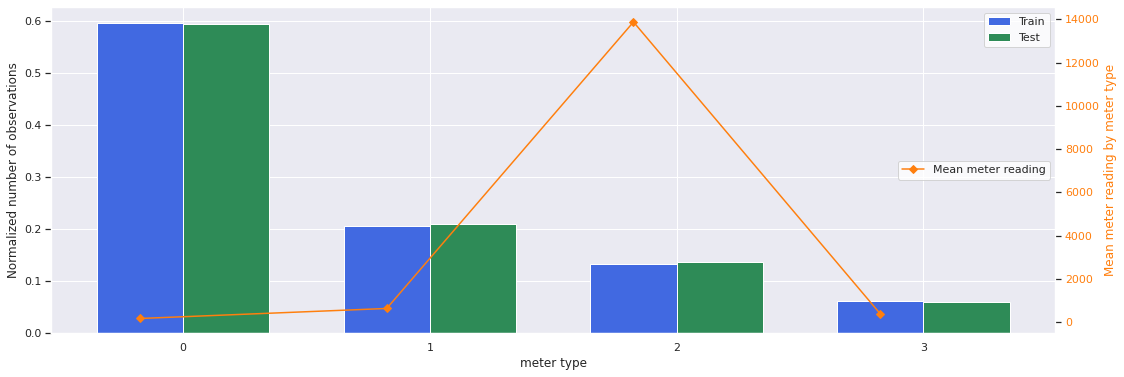

In [ ]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(18, 6))
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

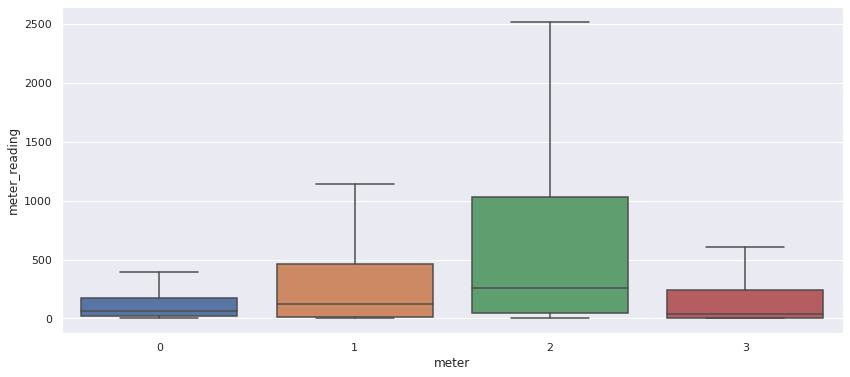

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

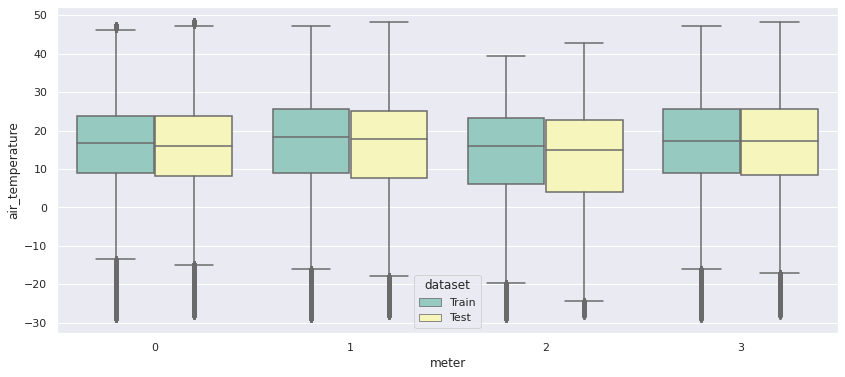

In [ ]:
tmp_df = pd.concat([train[['meter', 'air_temperature']], test[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

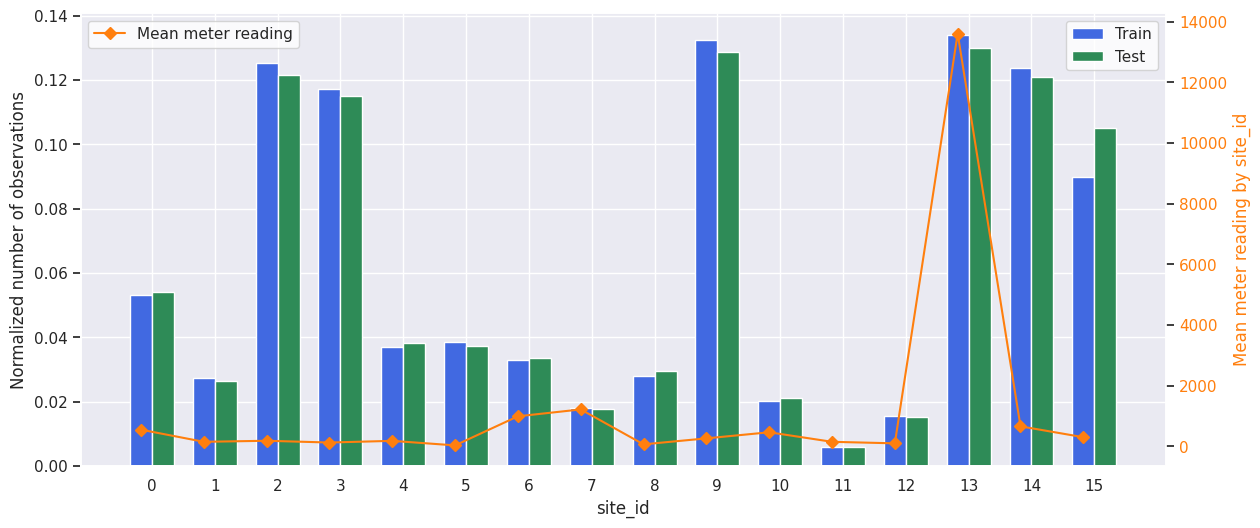

In [ ]:
train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

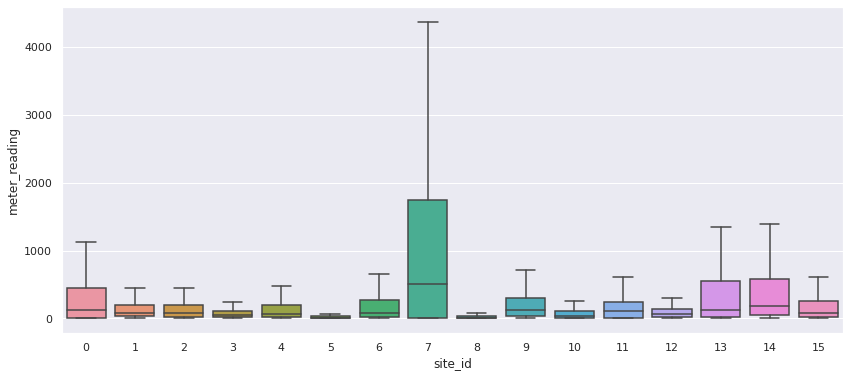

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

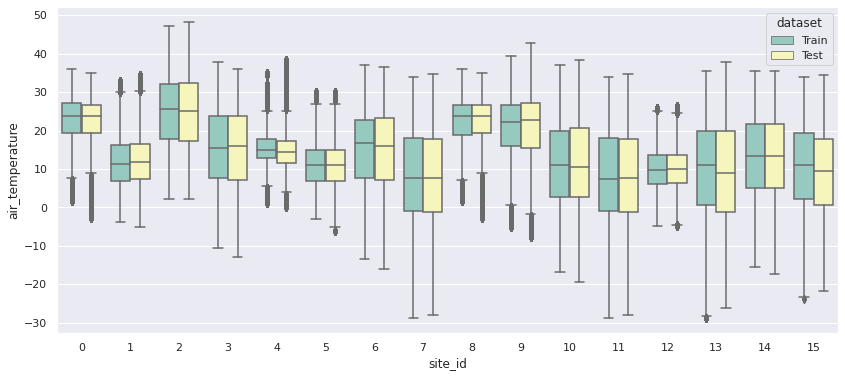

In [ ]:
tmp_df = pd.concat([train[['site_id', 'air_temperature']], test[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();


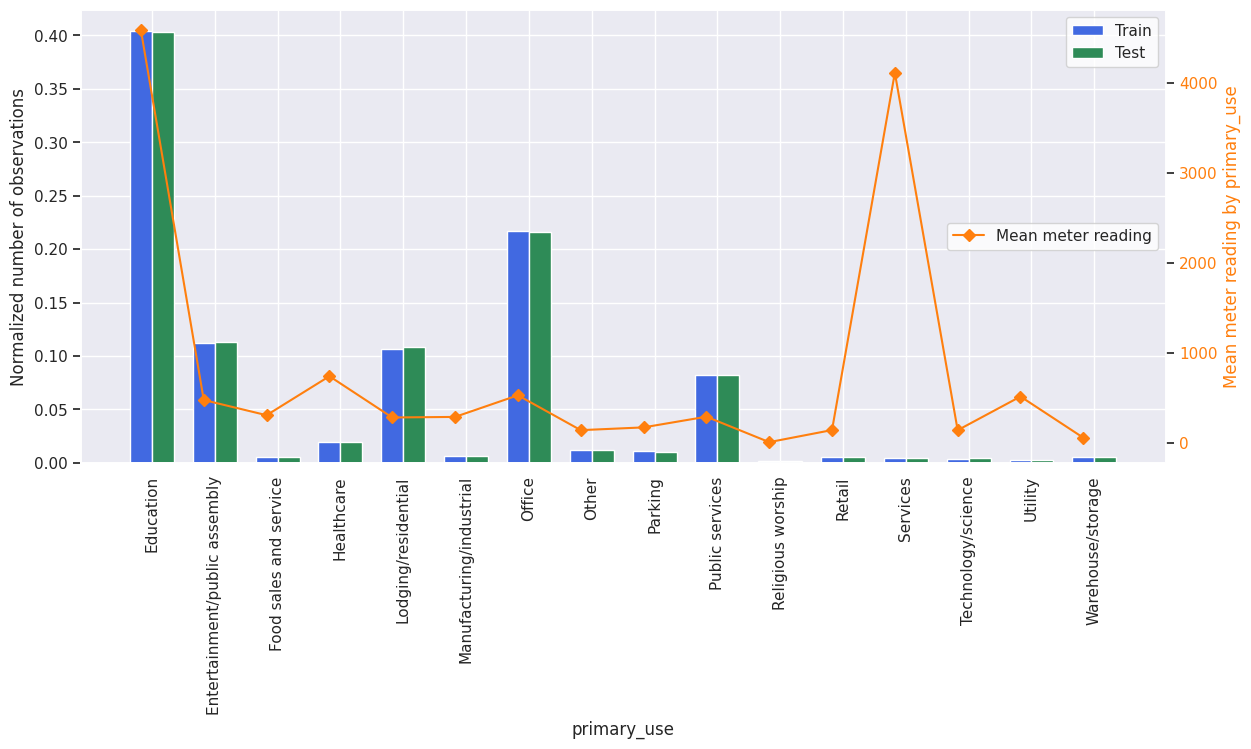

In [ ]:
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

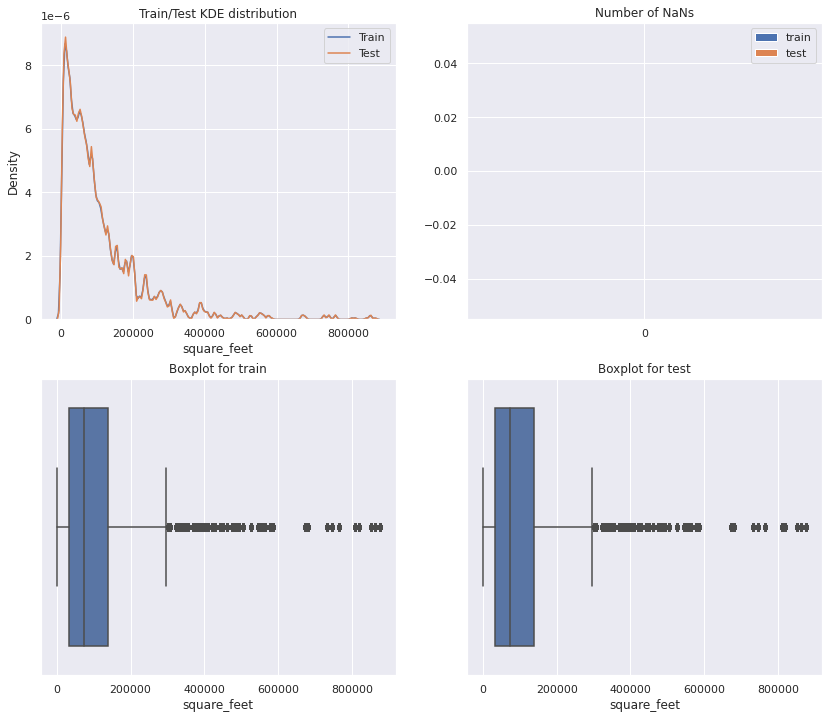

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

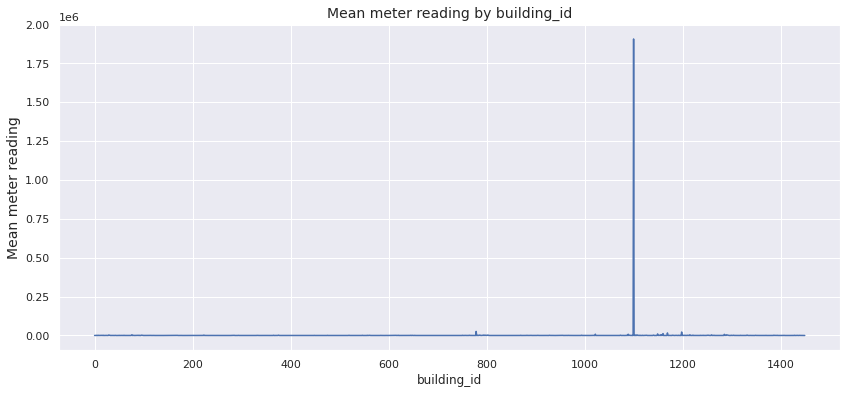

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

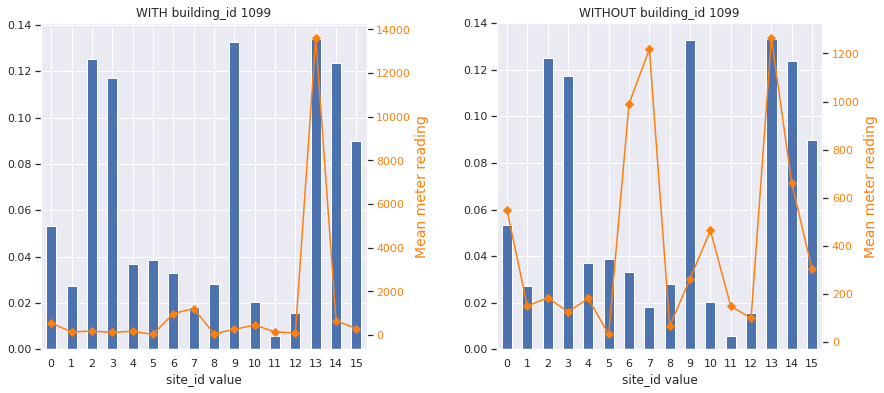

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train[train['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train[train['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

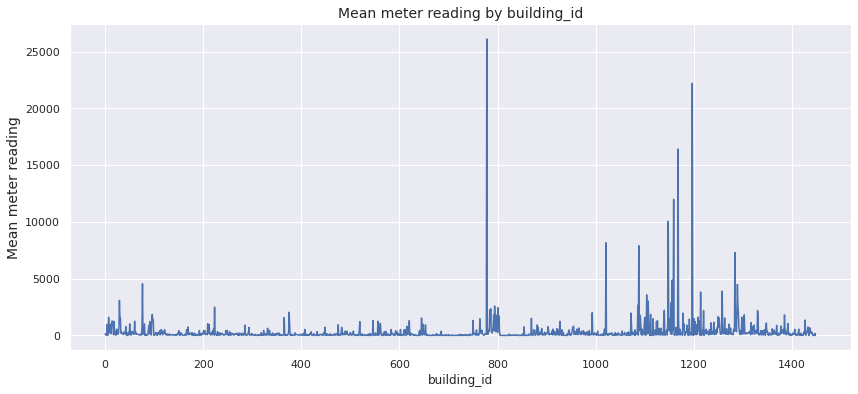

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

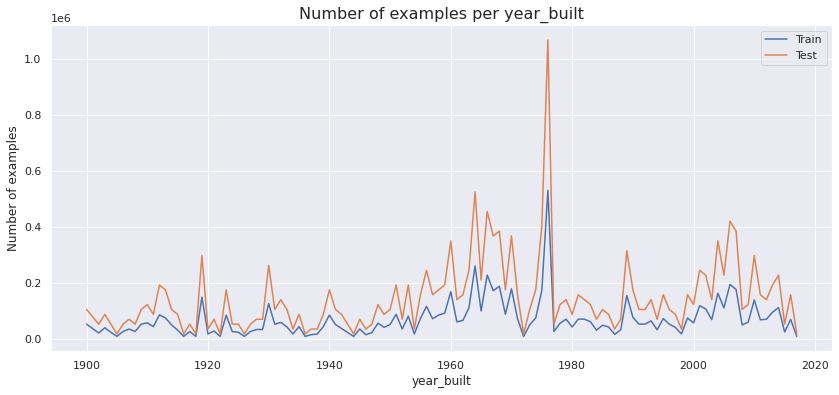

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('year_built');
test['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_ylabel('Number of examples');
axes.legend(['Train', 'Test']);
axes.set_title('Number of examples per year_built', fontsize=16);

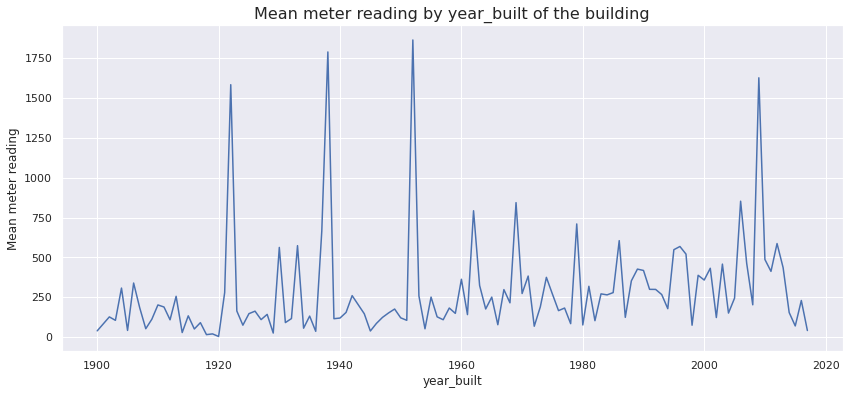

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

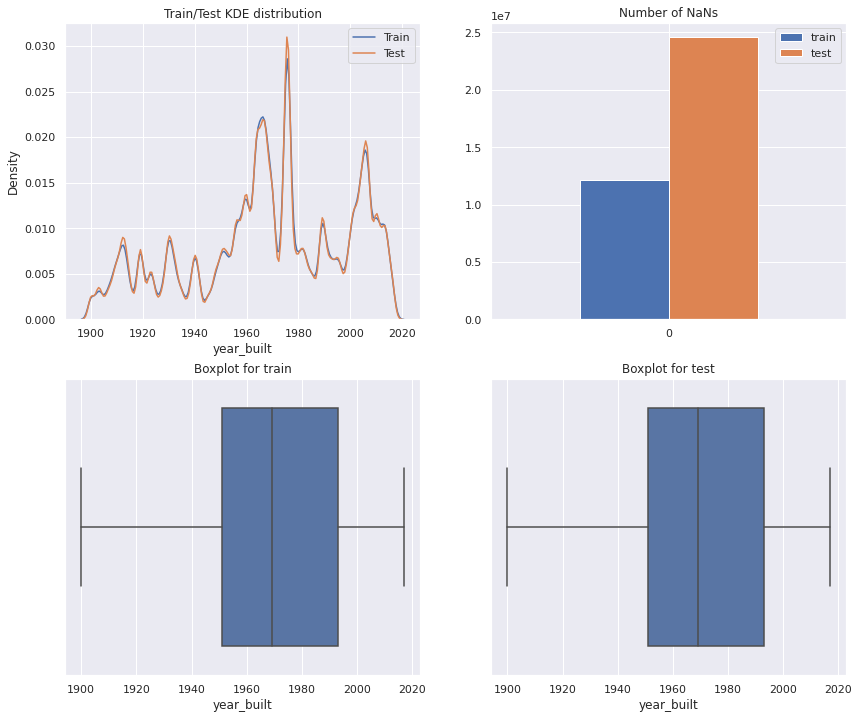

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test['year_built'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['year_built'], ax=axes[1][0]);
sns.boxplot(x=test['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train['year_built'].isnull().sum()], 'test': [test['year_built'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

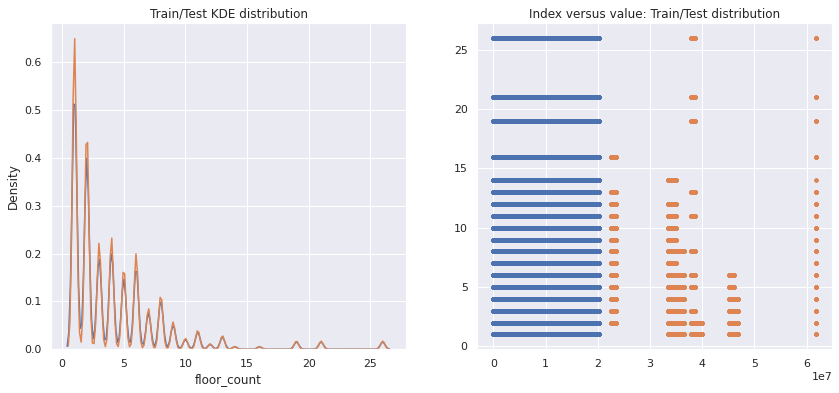

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(train['floor_count'], label='Train', ax=axes[0]);
sns.kdeplot(test['floor_count'], label='Test', ax=axes[0]);
test.index += len(train)
axes[1].plot(train['floor_count'], '.', label='Train');
axes[1].plot(test['floor_count'], '.', label='Test');
test.index -= len(train)
axes[0].set_title('Train/Test KDE distribution');
axes[1].set_title('Index versus value: Train/Test distribution');
gc.collect();

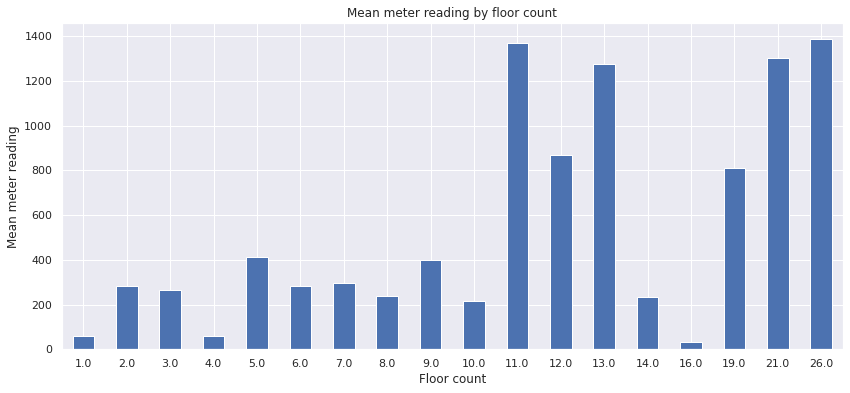

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
pd.Series(index=train['floor_count'].value_counts().index, 
          data=train.groupby('floor_count')['meter_reading'].transform('mean').value_counts().index).sort_index().plot(kind='bar', rot=0, ax=axes);
axes.set_xlabel('Floor count');
axes.set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by floor count');

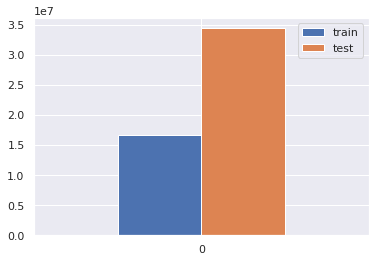

In [ ]:
pd.DataFrame({'train': [train['floor_count'].isnull().sum()], 'test': [test['floor_count'].isnull().sum()]}).plot(kind='bar', rot=0);

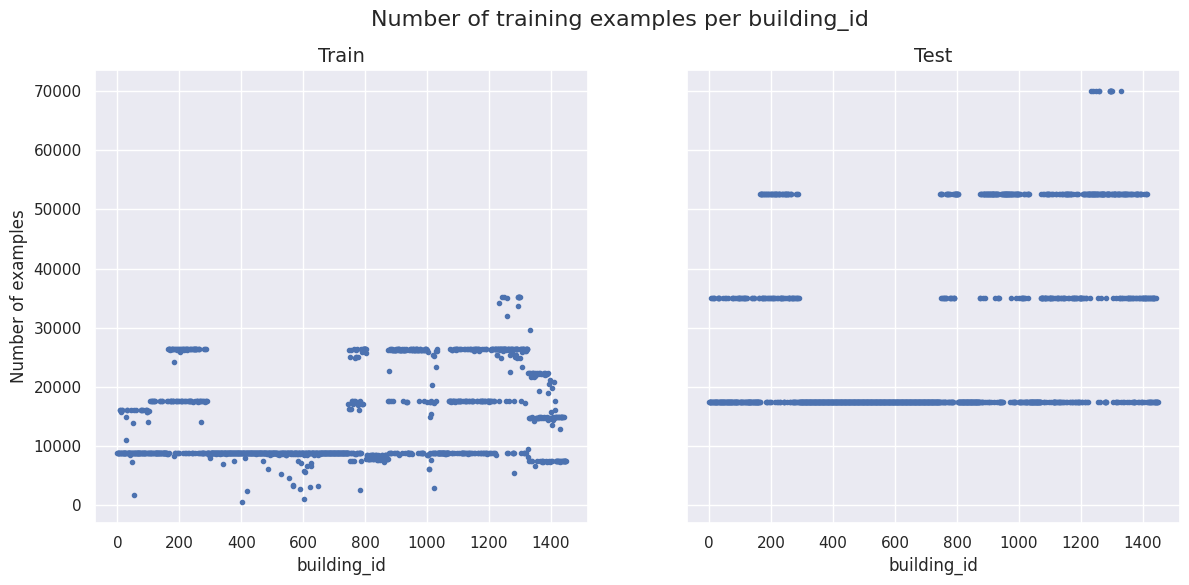

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14, 6), sharey=True, dpi=100)
axes[0].plot(train['building_id'].value_counts().sort_index(), '.');
axes[1].plot(test['building_id'].value_counts().sort_index(), '.');
axes[0].set_title('Train', fontsize=14);
axes[1].set_title('Test', fontsize=14);
axes[0].set_xlabel('building_id');
axes[1].set_xlabel('building_id');
axes[0].set_ylabel('Number of examples');
fig.suptitle('Number of training examples per building_id', fontsize=16);

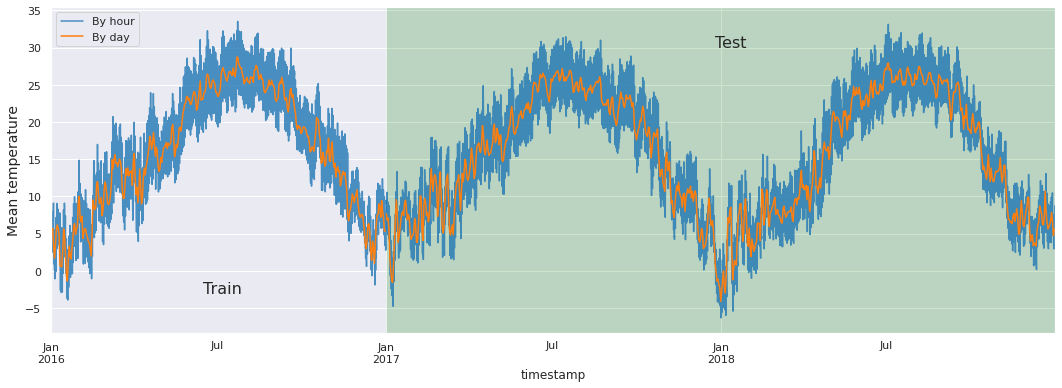

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(18, 6))
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=14);
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], -3, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[29400000], 30, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);


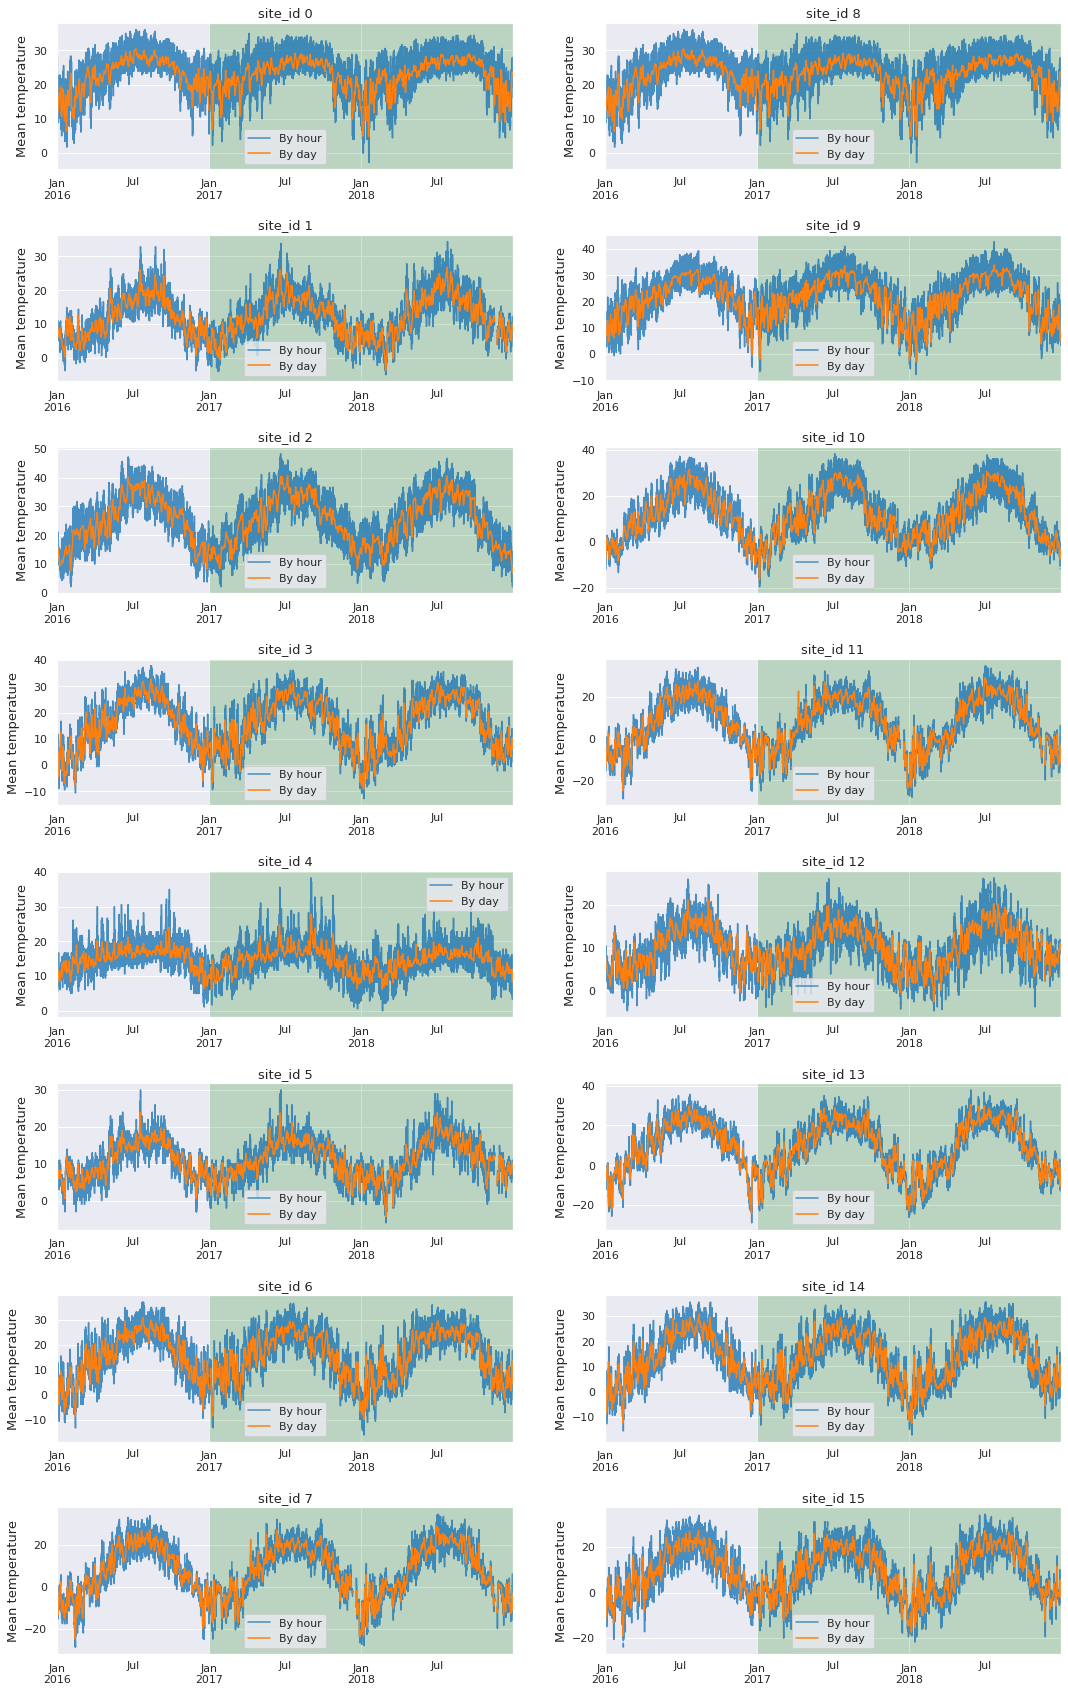

In [ ]:
fig, axes = plt.subplots(8,2,figsize=(18, 30))
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

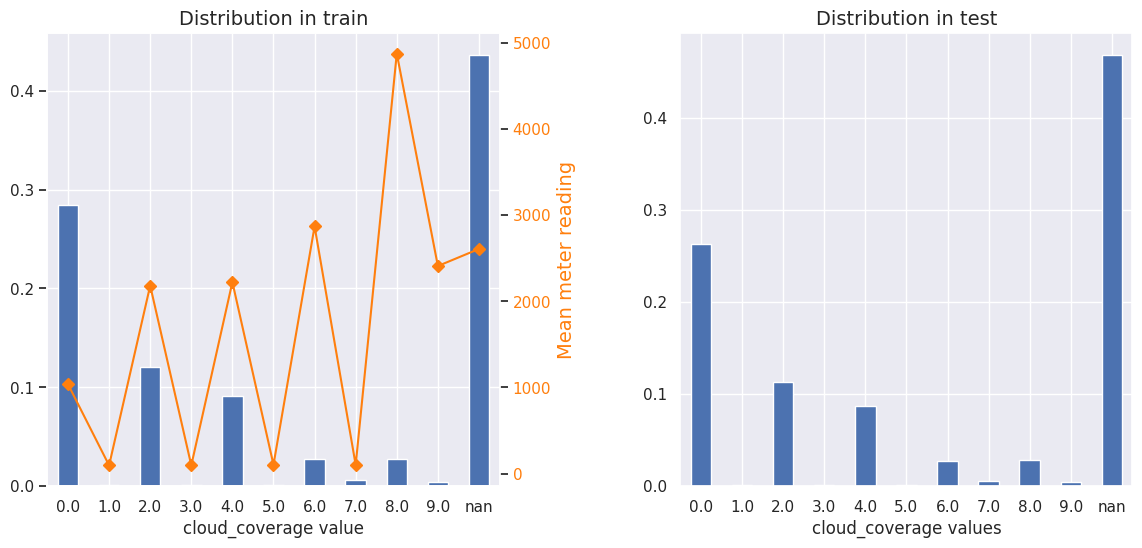

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
train['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('cloud_coverage value');
test['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('cloud_coverage values');
axes[0].set_title('Distribution in train', fontsize=14);
axes[1].set_title('Distribution in test', fontsize=14);
ax2 = axes[0].twinx()
train[['cloud_coverage', 'meter_reading']].replace(np.nan, 'nan').groupby('cloud_coverage')['meter_reading'].mean().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.set_xticklabels(train['cloud_coverage'].value_counts(dropna=False).sort_index().index)
plt.subplots_adjust(wspace=0.4);